In [1]:
import cv2
import os

def extract_frames_from_video_segment(video_path, start_time, end_time, output_dir, frame_rate=None):
    """
    Извлекает кадры из определенной части видео.

    Args:
        video_path (str): Путь к видеофайлу.
        start_time (float): Начальное время в секундах.
        end_time (float): Конечное время в секундах.
        output_dir (str): Директория для сохранения кадров.
        frame_rate (float, optional): Частота кадров. Если не указана,
                                      используется частота видео.
    """

    # Проверка существования директории
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Открытие видеофайла
    video_capture = cv2.VideoCapture(video_path)

    if not video_capture.isOpened():
        print(f"Ошибка открытия видео: {video_path}")
        return

    # Определение частоты кадров
    if frame_rate is None:
        frame_rate = video_capture.get(cv2.CAP_PROP_FPS)
    # Преобразование времени в кадры
    start_frame = int(start_time * frame_rate)
    end_frame = int(end_time * frame_rate)

    # Перемещение к начальному кадру
    video_capture.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    current_frame = start_frame
    while True:
        ret, frame = video_capture.read()
        current_time = current_frame/frame_rate
        if not ret or current_frame > end_frame:
            break

        # Формирование имени файла
        file_name = os.path.splitext(os.path.basename(video_path))[0]
        output_path = os.path.join(output_dir, file_name+"_"+str(current_frame)+"_"+str(current_time)+".jpg")
        # Сохранение кадра
        cv2.imwrite(output_path, frame)


        current_frame += 1

    video_capture.release()

In [2]:
import json

In [3]:
def get_subdirectories(directory):
    return [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]

video_dirs_list_train = get_subdirectories('data_train_short/')
video_dirs_list_test = get_subdirectories('data_test_short/')

In [4]:
timings_train = "labels_json/train_labels.json"
with open(timings_train, 'r',encoding='utf-8') as fcc_file: 
    fcc_data_train = json.load(fcc_file)
    #print(json.dumps(fcc_data, indent=4))

def get_sec(time_str):
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

In [5]:
timings_test = "labels_json/test_labels.json"
with open(timings_test, 'r',encoding='utf-8') as fcc_file: 
    fcc_data_test = json.load(fcc_file)
    #print(json.dumps(fcc_data, indent=4))

for i in fcc_data_test:
    file_name = os.listdir('data_test_short/'+i)
    start_time = int(get_sec(fcc_data_test[i]["start"]))
    end_time = int(get_sec(fcc_data_test[i]["end"]))
    duration = end_time - start_time
    extract_frames_from_video_segment('data_test_short/'+i+"/"+file_name[0], start_time, end_time, "frames/validation/output_frames_OP")
    extract_frames_from_video_segment('data_test_short/'+i+"/"+file_name[0], end_time+1, end_time+1+duration, "frames/validation/output_frames_not_OP")

'for i in fcc_data_test:\n    file_name = os.listdir(\'data_test_short/\'+i)\n    start_time = int(get_sec(fcc_data_test[i]["start"]))\n    end_time = int(get_sec(fcc_data_test[i]["end"]))\n    duration = end_time - start_time\n    extract_frames_from_video_segment(\'data_test_short/\'+i+"/"+file_name[0], start_time, end_time, "frames/validation/output_frames_OP")\n    extract_frames_from_video_segment(\'data_test_short/\'+i+"/"+file_name[0], end_time+1, end_time+1+duration, "frames/validation/output_frames_not_OP")'

In [6]:
for i in fcc_data_train:
    file_name = os.listdir('data_train_short/'+i)
    start_time = int(get_sec(fcc_data_train[i]["start"]))
    end_time = int(get_sec(fcc_data_train[i]["end"]))
    duration = end_time - start_time
    extract_frames_from_video_segment('data_train_short/'+i+"/"+file_name[0], start_time, end_time, "frames/train/output_frames_OP")
    extract_frames_from_video_segment('data_train_short/'+i+"/"+file_name[0], end_time+1, end_time+1+duration, "frames/train/output_frames_not_OP")

'for i in fcc_data_train:\n    file_name = os.listdir(\'data_train_short/\'+i)\n    start_time = int(get_sec(fcc_data_train[i]["start"]))\n    end_time = int(get_sec(fcc_data_train[i]["end"]))\n    duration = end_time - start_time\n    extract_frames_from_video_segment(\'data_train_short/\'+i+"/"+file_name[0], start_time, end_time, "frames/train/output_frames_OP")\n    extract_frames_from_video_segment(\'data_train_short/\'+i+"/"+file_name[0], end_time+1, end_time+1+duration, "frames/train/output_frames_not_OP")'

In [7]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import skimage
from skimage import io, transform
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

In [8]:
def data_transforms(phase):
    if phase == 'train':
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
            transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5)
        ])
        
    if phase == 'validation':
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
   
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])       
        
    return transform
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
image_datasets = {x: datasets.ImageFolder(os.path.join("frames/", x), data_transforms(x))
                  for x in ['validation','train']}

dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size = 4, shuffle=True), 
               'validation': torch.utils.data.DataLoader(image_datasets['validation'], batch_size = 1, shuffle=False)}

In [10]:
len(dataloaders['train'])

4258

In [11]:
len(dataloaders['validation'])

18582

In [12]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
classes = image_datasets['train'].classes
class_names = image_datasets['train'].classes

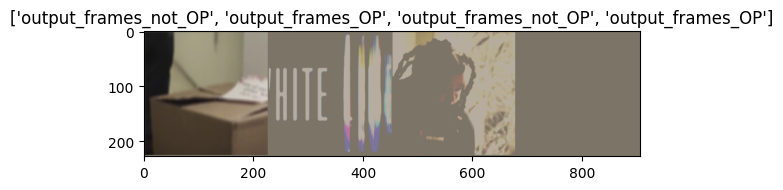

In [13]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [14]:
inputs, classes = next(iter(dataloaders['train']))

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        print("="*10)
        
        for phase in ['train', 'validation']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for data in dataloaders[phase]:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

In [24]:
model_pre = models.efficientnet_b0()

In [25]:
for param in model_pre.features.parameters():
    param.required_grad = False

model_pre.classifier[1] = nn.Linear(in_features=1280, out_features=2)

print(model_pre)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [26]:
model_pre = model_pre.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pre.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [27]:
model_pre = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=30)

Epoch: 1/30
train Loss: 0.7010 Acc: 0.5244
validation Loss: 1.5832 Acc: 0.4628
Epoch: 2/30
train Loss: 0.6940 Acc: 0.5245
validation Loss: 0.6950 Acc: 0.5117
Epoch: 3/30
train Loss: 0.6639 Acc: 0.5931
validation Loss: 0.5475 Acc: 0.8013
Epoch: 4/30
train Loss: 0.5826 Acc: 0.6771
validation Loss: 0.5445 Acc: 0.7930
Epoch: 5/30
train Loss: 0.4825 Acc: 0.7511
validation Loss: 0.4995 Acc: 0.7930
Epoch: 6/30
train Loss: 0.4069 Acc: 0.8052
validation Loss: 0.5227 Acc: 0.7347
Epoch: 7/30
train Loss: 0.3498 Acc: 0.8382
validation Loss: 0.5900 Acc: 0.7400
Epoch: 8/30
train Loss: 0.3002 Acc: 0.8652
validation Loss: 0.5984 Acc: 0.7481
Epoch: 9/30
train Loss: 0.2647 Acc: 0.8813
validation Loss: 0.7617 Acc: 0.6256
Epoch: 10/30
train Loss: 0.1857 Acc: 0.9170
validation Loss: 0.8648 Acc: 0.6285
Epoch: 11/30
train Loss: 0.1612 Acc: 0.9254
validation Loss: 0.8673 Acc: 0.6674
Epoch: 12/30
train Loss: 0.1521 Acc: 0.9299
validation Loss: 0.8510 Acc: 0.6767
Epoch: 13/30
train Loss: 0.1454 Acc: 0.9324
valid

In [28]:
def test_model():
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    f = open("test_y", "w")
    with torch.no_grad():
        for data in dataloaders['validation']:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            true_labels.append(labels.item())
            outputs = model_pre(inputs)
            _, preds = torch.max(outputs.data, 1)
            pred_labels.append(preds.item())
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()
        acc = running_correct/running_total
    return (true_labels, pred_labels, running_correct, running_total, acc)

In [29]:
true_labels, pred_labels, running_correct, running_total, acc = test_model()

In [30]:
print("Total Correct: {}, Total Test Images: {}".format(running_correct, running_total))
print("Test Accuracy: ", acc)


Total Correct: 14890.0, Total Test Images: 18582.0
Test Accuracy:  0.8013130986976644


In [45]:
cats = ["output_frames_OP", "output_frames_not_OP"]
def prediction():
    df = pd.DataFrame(columns = ['image_id',"output_frames_OP", "output_frames_not_OP"])
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        for j,data in enumerate(dataloaders['validation']):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            true_labels.append(labels.item())
            outputs = model_pre(inputs).squeeze()
            outputs1 = model_pre(inputs)
            _, preds = torch.max(outputs1.data, 1)
            res = outputs.softmax(dim = 0).sort(descending = True)
            #Получение имени файла
            img_id = os.path.basename(dataloaders['validation'].dataset.samples[j][0])
            row = {'image_id': img_id}
            for s,i in zip(res[0][:2], res[1][:2]):
                row[cats[i]] = s.item()
            df_row = pd.DataFrame([row])
            df = pd.concat([df,df_row])
    return df
  

In [46]:
df = prediction()

C:\Users\Ainur\AppData\Local\Temp\ipykernel_1592\660004577.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df_row])


KeyboardInterrupt: 

In [33]:
df.head()

NameError: name 'df' is not defined

In [ ]:
df.to_csv('out.csv', index=False)  